# Long-term Memory for AI Agents

Long-term memory allows agents to remember important information across conversations. LangMem provides ways to extract meaningful details from chats, store them, and use them to improve future interactions.

The best memory systems are often application-specific. In designing yours, the following questions can serve as a useful guide:

1. What type of content should your agent learn: facts/knowledge? summary of past events? Rules and style?
2. When should the memories be formed (and who should form the memories)
3. Where should memories be stored? (in the prompt? Semantic store?). This largely determines how they will be recalled.

# 1. Understand [Types of Memory](https://langchain-ai.github.io/langmem/concepts/conceptual_guide/#memory-types)

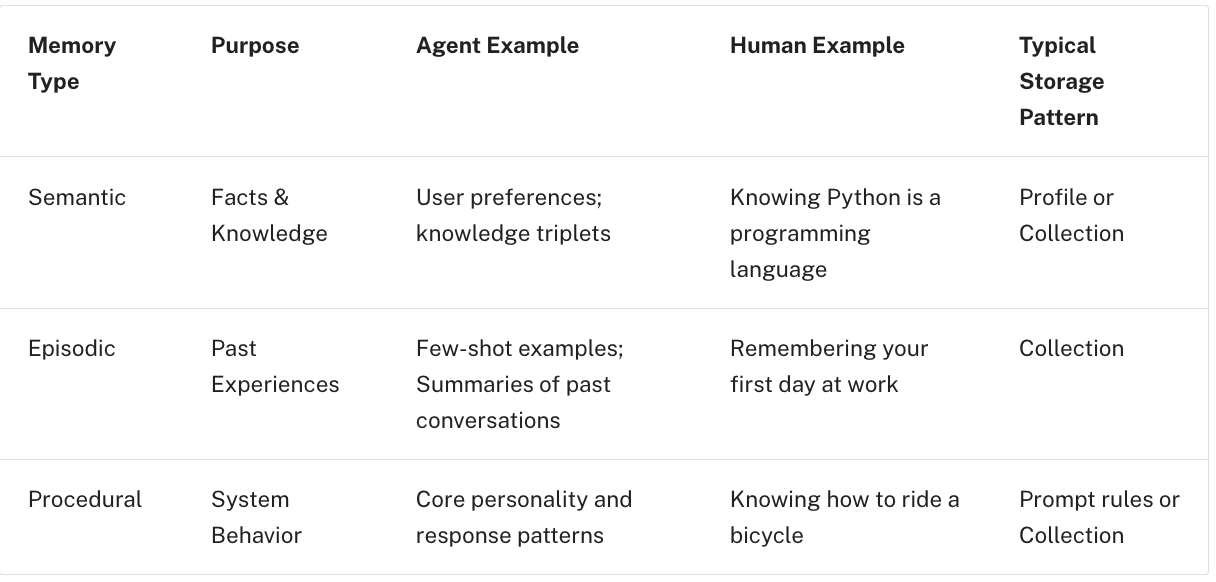

# 2. Understand Core APIs in LangMem and Storage

### Setup

In [1]:
!pip install -Uq pydantic langmem langchain-google-genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.1/420.1 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
from google.colab import userdata
import os

os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")

# Core Primitives of LangMem

LangMem's memory utilities are organized in two layers of integration patterns:

1. **Core API**: At its heart, LangMem provides functions that transform memory state without side effects. These primitives are the building blocks for memory operations:
  - **Memory Managers:** Extract new memories, update or remove outdated memories, and consolidate and generalize from existing memories based on new conversation information
  - **Prompt Optimizers:** Update prompt rules and core behavior based on conversation information (with optional feedback)
2. **Storage Integration**: The next layer up powered with LangGraph's long-term memory store. These components use the core API above to transform memories that existing in the store and upsert/delete them as needed when new conversation information comesin.

Good thing is that Store is just Data Layer so we can use it with OpenAI Agents SDK - better we don't have work on Agentic DB CRUD as we start taking baby steps to build Memory Layer for our AI Agents.

## 1. Memory API (Extractive Memory)

### a. **create_memory_manager**

Create a memory manager that processes conversation messages and generates structured memory entries.

This function creates an async callable that analyzes conversation messages and existing memories to generate or update structured memory entries. It can identify implicit preferences, important context, and key information from conversations, organizing them into well-structured memories that can be used to improve future interactions.

The manager supports both unstructured string-based memories and structured memories defined by Pydantic models, all automatically persisted to the configured storage.

[Reference](https://langchain-ai.github.io/langmem/reference/memory/#langmem.create_memory_manager)

In [10]:
# Basic Config Values
MODEL = "google_genai:gemini-2.0-flash"

preference_conversation = [
    {"role": "user", "content": "I prefer dark mode in all my apps"},
    {"role": "assistant", "content": "I'll remember that preference"},
]


#### **A. Basic unstructured memory enrichment:**

Create Memories from User Conversation

In [12]:
from langmem import create_memory_manager

manager = create_memory_manager(MODEL)

# Extract memories from conversation
memories = await manager.ainvoke({"messages": preference_conversation})
print("\n[MEM]", memories, "\n")
print(memories[0][1])  # First memory's content
# Output: "User prefers dark mode for all applications"


[MEM] [ExtractedMemory(id='5ce0fc5b-d4f3-4675-80f5-6ae528a2eac4', content=Memory(content='The user prefers dark mode in all apps.'))] 

content='The user prefers dark mode in all apps.'


#### **B. Structured memory enrichment with Pydantic models:**

Now rather than unstructured text lets give our memories a structure

In [13]:
from pydantic import BaseModel
from langmem import create_memory_manager

class PreferenceMemory(BaseModel):
    """Store the user's preference"""
    category: str
    preference: str
    context: str

manager = create_memory_manager(
    MODEL,
    schemas=[PreferenceMemory]
)


memories = await manager.ainvoke({"messages": preference_conversation})
print("\n[MEM]", memories, "\n")
print(memories[0][1])
# Output:
# PreferenceMemory(
#     category="ui",
#     preference="dark_mode",
#     context="User explicitly stated preference for dark mode in all applications"
# )


[MEM] [ExtractedMemory(id='a25c906f-5424-4828-812b-9f308ed1332b', content=PreferenceMemory(category='User Preference', preference='Prefers dark mode', context='App Interface'))] 

category='User Preference' preference='Prefers dark mode' context='App Interface'


In [14]:
memories[0].content

PreferenceMemory(category='User Preference', preference='Prefers dark mode', context='App Interface')

**Continue Working with existing memories:**

In [15]:
conversation = [
    {
        "role": "user",
        "content": "Actually I changed my mind, dark mode hurts my eyes",
    },
    {"role": "assistant", "content": "I'll update your preference"},
]

# The manager will upsert; working with the existing memory instead of always creating a new one
updated_memories = await manager.ainvoke(
    {"messages": conversation, "existing": memories}
)

In [16]:
updated_memories

[ExtractedMemory(id='a25c906f-5424-4828-812b-9f308ed1332b', content=PreferenceMemory(category='User Preference', preference='Does not prefer dark mode', context='App Interface'))]

#### **C. Providing multiple max steps for extraction and synthesis::**

In [17]:
manager = create_memory_manager(
    MODEL,
    schemas=[PreferenceMemory],
)

conversation = [
    {"role": "user", "content": "I prefer dark mode in all my apps"},
    {"role": "assistant", "content": "I'll remember that preference"},
]

# Set max steps for extraction and synthesis
max_steps = 4
memories = await manager.ainvoke({"messages": conversation, "max_steps": max_steps})
print(memories)

[ExtractedMemory(id='8cc45ead-c96e-48bd-85b4-e8bab5899249', content=PreferenceMemory(category='application preference', preference='dark mode', context='all apps'))]


In [18]:
# Set max steps for extraction and synthesis
max_steps = 0
memories = await manager.ainvoke({"messages": conversation, "max_steps": max_steps})
print(memories)

[]


In [20]:
memories = await manager.ainvoke({"messages": conversation})
print(memories)

[ExtractedMemory(id='ec5484d8-7b9c-4db7-bb0e-a3141ecf9659', content=PreferenceMemory(category='application preference', preference='dark mode', context='all apps'))]


------------------------------------------------------------------------------

#### Quick Note on LangGraph Storage

When using LangMem's stateful operators, the storage system is built on LangGraph's storage primitives, providing a flexible and powerful way to organize and access memories. The storage system is designed around two concepts:
1. Memory Namespaces
2. Flexible Retrieval

**What the Heck is this Langgraph Store?**
It is just data layer so we can save and reterive data from a Data Storage easily using BaseStore. In OOS ecosystem the [BaseStore](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) have ready to use implementations for storage systems like
- [PostGress Relational DB](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.postgres.aio.AsyncPostgresSaver_
- [Redis](https://github.com/redis-developer/langgraph-redis)
- InMemryStore for quick implementations

All are using the same primitives of BaseStore.


------------------------------------------------------------------------------------

### b. **create_memory_store_manager**

Enriches memories stored in the configured BaseStore.

The system automatically searches for relevant memories, extracts new information, updates existing memories, and maintains a versioned history of all changes.


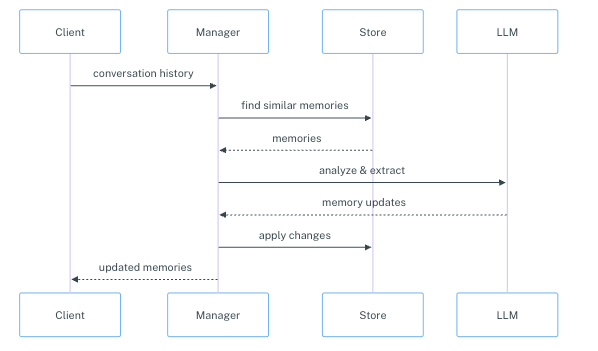

In [22]:
from pydantic import BaseModel

from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langgraph.store.memory import InMemoryStore

from langmem import create_memory_store_manager


class PreferenceMemory(BaseModel):
    """Store preferences about the user."""
    category: str
    preference: str
    context: str

embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")


store = InMemoryStore(
      index={
          "dims": 768,
          "embed": embeddings,
      }
    )

# Initialize memory manager with custom store
manager = create_memory_store_manager(
    MODEL,
    schemas=[PreferenceMemory],
    namespace=("AI-201", "{panaversity_user_id}"),
    store=store
)

async def run_example():

    # Simulate a conversation
    conversation = [
        {"role": "user", "content": "I prefer dark mode in all my apps"},
        {"role": "assistant", "content": "I'll remember that preference"}
    ]

    print("Process the conversation and store memories...")
    await manager.ainvoke(
        {"messages": conversation},
        config={"configurable": {"panaversity_user_id": "user123"}}
    )

    # Retrieve and display stored memories
    print("\nStored memories:")
    memories = store.search(("AI-201", "user123"))
    for memory in memories:
        print(f"\nMemory {memory.key}:")
        print(f"Content: {memory.value['content']}")
        print(f"Kind: {memory.value['kind']}")



import asyncio
print("\nStarting custom store example...\n")
asyncio.run(run_example())
print("\nExample completed.\n")


Starting custom store example...

Process the conversation and store memories...

Stored memories:

Memory 072757c0-c463-4dda-b622-d9faeb386012:
Content: {'category': 'User Interface', 'preference': 'Prefers dark mode', 'context': 'Applications'}
Kind: PreferenceMemory

Example completed.



In [23]:
# You can list over memories in the user's namespace manually:
print(store.search(("AI-201", "user123")))

[Item(namespace=['AI-201', 'user123'], key='072757c0-c463-4dda-b622-d9faeb386012', value={'kind': 'PreferenceMemory', 'content': {'category': 'User Interface', 'preference': 'Prefers dark mode', 'context': 'Applications'}}, created_at='2025-03-31T00:41:09.151086+00:00', updated_at='2025-03-31T00:41:09.151092+00:00', score=None)]


## 2. Memory Tools

- create_manage_memory_tool – Create a tool for managing persistent memories in conversations.
- create_search_memory_tool – Create a tool for searching memories stored in a LangGraph BaseStore.


### a. [**create_manage_memory_tool**](https://langchain-ai.github.io/langmem/reference/tools/#langmem.create_manage_memory_tool)

In [42]:
from langmem import create_manage_memory_tool
from langgraph.store.memory import InMemoryStore

store = InMemoryStore(
      index={
          "dims": 768,
          "embed": embeddings,
      }
    )

namespace=("project_memories", "memory")

memory_tool = create_manage_memory_tool(
    namespace=namespace,
    store=store
)

print(type(memory_tool))
memory_tool

<class 'langchain_core.tools.structured.StructuredTool'>


StructuredTool(name='manage_memory', description='Create, update, or delete persistent MEMORIES to persist across conversations.\nInclude the MEMORY ID when updating or deleting a MEMORY. Omit when creating a new MEMORY - it will be created for you.\nProactively call this tool when you:\n\n1. Identify a new USER preference.\n2. Receive an explicit USER request to remember something or otherwise alter your behavior.\n3. Are working and want to record important context.\n4. Identify that an existing MEMORY is incorrect or outdated.', args_schema=<class 'langchain_core.utils.pydantic.manage_memory'>, func=<function create_manage_memory_tool.<locals>.manage_memory at 0x7e93706b4cc0>, coroutine=<function create_manage_memory_tool.<locals>.amanage_memory at 0x7e93706b4b80>)

Now we can pass this LangChain tool to any Agent and automate the agent -> memories -> storage pipeline

In [43]:
# THis name space have no data in store
store.search(namespace)

[]

In [44]:
# Manually Invoke the tool
memory_tool.invoke(input={"content": "I am Junaid"})

'created memory 78c0c098-dddd-40a4-9ee3-ea354a8e8b86'

In [45]:
store.search(namespace)

[Item(namespace=['project_memories', 'memory'], key='78c0c098-dddd-40a4-9ee3-ea354a8e8b86', value={'content': 'I am Junaid'}, created_at='2025-03-31T00:52:42.262173+00:00', updated_at='2025-03-31T00:52:42.262179+00:00', score=None)]

### b. [**create_search_memory_tool**](https://langchain-ai.github.io/langmem/reference/tools/#langmem.create_search_memory_tool)

This function creates a tool that allows AI assistants to search through previously stored memories using semantic or exact matching. The tool returns both the memory contents and the raw memory objects for advanced usage.

In [58]:
from langmem import create_search_memory_tool
from langgraph.store.memory import InMemoryStore

store = InMemoryStore(
      index={
          "dims": 768,
          "embed": embeddings,
      }
    )

namespace=("project_memories", "memory")

search_memory_tool = create_search_memory_tool(
    namespace=namespace,
    store=store
)

print(type(search_memory_tool))
search_memory_tool

<class 'langchain_core.tools.structured.StructuredTool'>


StructuredTool(name='search_memory', description='Search your long-term memories for information relevant to your current context.', args_schema=<class 'langchain_core.utils.pydantic.search_memory'>, func=<function create_search_memory_tool.<locals>.search_memory at 0x7e937067ea20>, coroutine=<function create_search_memory_tool.<locals>.asearch_memory at 0x7e937067f420>)

In [59]:
# THis name space have no data in store
print(store.search(namespace))

# Addings some memories using the create tool...
create_manage_memory_tool(
    namespace=namespace,
    store=store
).invoke(input={"content": "I am Junaid"})

# THis name space have no data in store
print(store.search(namespace))

[]
[Item(namespace=['project_memories', 'memory'], key='272bfbc5-afd3-4ab5-9fa8-789dcde2da9d', value={'content': 'I am Junaid'}, created_at='2025-03-31T00:56:41.349466+00:00', updated_at='2025-03-31T00:56:41.349475+00:00', score=None)]


In [61]:
# Now let's create a search tool and use it to find relevant memories.
search_memory_tool.invoke(input={"query": "Who am I?"})

[{'namespace': ['project_memories', 'memory'],
  'key': '272bfbc5-afd3-4ab5-9fa8-789dcde2da9d',
  'value': {'content': 'I am Junaid'},
  'created_at': '2025-03-31T00:56:41.349466+00:00',
  'updated_at': '2025-03-31T00:56:41.349475+00:00',
  'score': 0.5579883794519429}]

## 3. Prompt Optimization

Now that was one part now let's look at how to optimize our prompts

### A. **create_prompt_optimizer**

Create a prompt optimizer that improves prompt effectiveness.
This function creates an optimizer that can analyze and improve prompts for better performance with language models. It supports multiple optimization strategies to iteratively enhance prompt quality and effectiveness.

#### 1. Basic prompt optimization:

In [24]:
from langmem import create_prompt_optimizer

optimizer = create_prompt_optimizer(MODEL)

# Example conversation with feedback
conversation = [
    {"role": "user", "content": "Tell me about the solar system"},
    {"role": "assistant", "content": "The solar system consists of..."},
]

feedback = {"clarity": "needs more structure"}

# Use conversation history to improve the prompt
trajectories = [(conversation, feedback)]
better_prompt = await optimizer.ainvoke(
    {"trajectories": trajectories, "prompt": "You are an astronomy expert"}
)
print(better_prompt)
# Output: 'Provide a comprehensive overview of the solar system...'

You are an astronomy expert. Structure the information about the solar system in a logical way, such as by category (planets, dwarf planets, other objects) or by distance from the sun. 


#### 2. Optimizing with conversation feedback:

In [25]:
from langmem import create_prompt_optimizer

optimizer = create_prompt_optimizer(
    MODEL, kind="prompt_memory"
)

# Conversation with feedback about what could be improved
conversation = [
    {"role": "user", "content": "How do I write a bash script?"},
    {"role": "assistant", "content": "Let me explain bash scripting..."},
]
feedback = "Response should include a code example"

# Use the conversation and feedback to improve the prompt
trajectories = [(conversation, {"feedback": feedback})]
better_prompt = await optimizer(trajectories, "You are a coding assistant")
print(better_prompt)
# Output: 'You are a coding assistant that always includes...'

/usr/local/lib/python3.11/dist-packages/langchain_google_genai/chat_models.py:1410: UserWarning: ChatGoogleGenerativeAI.with_structured_output with dict schema has changed recently to align with behavior of other LangChain chat models. More context: https://github.com/langchain-ai/langchain-google/pull/772
  warnings.warn(


You are a coding assistant. When responding to questions about code, you should always include a code example.


#### 3. Meta-prompt optimization for complex tasks:

In [26]:
from langmem import create_prompt_optimizer

optimizer = create_prompt_optimizer(
    MODEL,
    kind="metaprompt",
    config={"max_reflection_steps": 3, "min_reflection_steps": 1},
)

# Complex conversation that needs better structure
conversation = [
    {"role": "user", "content": "Explain quantum computing"},
    {"role": "assistant", "content": "Quantum computing uses..."},
]
feedback = "Need better organization and concrete examples"

# Optimize with meta-learning
trajectories = [(conversation, feedback)]
improved_prompt = await optimizer(
    trajectories, "You are a quantum computing expert"
)
improved_prompt

'You are a quantum computing expert. Explain quantum computing in a structured manner, including an introduction, key principles, and real-world applications. Use bullet points or numbered lists where appropriate to enhance clarity and organization. Provide concrete examples to illustrate complex concepts.'

### B. **create_multi_prompt_optimizer**

#### 1. Basic prompt optimization:


In [27]:
from langmem import create_multi_prompt_optimizer

optimizer = create_multi_prompt_optimizer(MODEL)

# Example conversation with feedback
conversation = [
    {"role": "user", "content": "Tell me about the solar system"},
    {"role": "assistant", "content": "The solar system consists of..."},
]
feedback = {"clarity": "needs more structure"}

# Use conversation history to improve the prompts
trajectories = [(conversation, feedback)]
prompts = [
    {"name": "research", "prompt": "Research the given topic thoroughly"},
    {"name": "summarize", "prompt": "Summarize the research findings"},
]
better_prompts = await optimizer.ainvoke(
    {"trajectories": trajectories, "prompts": prompts}
)
print(better_prompts)

[{'name': 'research', 'prompt': 'Research the given topic thoroughly'}, {'name': 'summarize', 'prompt': 'Summarize the research findings into sections such as planets, dwarf planets, other objects, and overall structure of the solar system. Focus on key points and make the summary concise and easy to understand for a general audience. Present the information in a logical order to ensure clarity and flow.'}]


#### 2. Optimizing with conversation feedback:


In [28]:
from langmem import create_multi_prompt_optimizer

optimizer = create_multi_prompt_optimizer(
    MODEL, kind="prompt_memory"
)

# Conversation with feedback about what could be improved
conversation = [
    {"role": "user", "content": "How do I write a bash script?"},
    {"role": "assistant", "content": "Let me explain bash scripting..."},
]
feedback = "Response should include a code example"

# Use the conversation and feedback to improve the prompts
trajectories = [(conversation, {"feedback": feedback})]
prompts = [
    {"name": "explain", "prompt": "Explain the concept"},
    {"name": "example", "prompt": "Provide a practical example"},
]
better_prompts = await optimizer(trajectories, prompts)

/usr/local/lib/python3.11/dist-packages/langchain_google_genai/chat_models.py:1410: UserWarning: ChatGoogleGenerativeAI.with_structured_output with dict schema has changed recently to align with behavior of other LangChain chat models. More context: https://github.com/langchain-ai/langchain-google/pull/772
  warnings.warn(


In [29]:
better_prompts

[{'name': 'explain', 'prompt': 'Explain the concept'},
 {'name': 'example',
  'prompt': 'Provide a practical example, including code where appropriate'}]

#### 3. Controlling the max number of reflection steps:

In [30]:
from langmem import create_multi_prompt_optimizer

optimizer = create_multi_prompt_optimizer(
    MODEL,
    kind="metaprompt",
    config={"max_reflection_steps": 3, "min_reflection_steps": 1},
)

# Complex conversation that needs better structure
conversation = [
    {"role": "user", "content": "Explain quantum computing"},
    {"role": "assistant", "content": "Quantum computing uses..."},
]
# Explicit feedback is optional
feedback = None

# Optimize with meta-learning
trajectories = [(conversation, feedback)]
prompts = [
    {"name": "concept", "prompt": "Explain quantum concepts"},
    {"name": "application", "prompt": "Show practical applications"},
    {"name": "example", "prompt": "Give concrete examples"},
]
improved_prompts = await optimizer(trajectories, prompts)

In [31]:
improved_prompts

[{'name': 'concept',
  'prompt': 'Explain quantum concepts completely and thoroughly, including key concepts and principles.'},
 {'name': 'application', 'prompt': 'Show practical applications'},
 {'name': 'example', 'prompt': 'Give concrete examples'}]